In [ ]:
#installing the required libraries and importing the VGG19 model for further modification on the base model

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50, ResNet50V2, VGG19, InceptionV3, InceptionResNetV2, VGG16
from tensorflow.keras.layers import Dropout, Flatten, Dense, Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.saving import load_model
from tensorflow.keras.optimizers import SGD, RMSprop
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import os
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import average_precision_score
import numpy as np
import pandas as pd

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jayanthmalladi","key":"censored"}'}

In [ ]:
os.makedirs('/content/dataset', exist_ok=True)

In [ ]:
!kaggle datasets download -d birdy654/cifake-real-and-ai-generated-synthetic-images

Dataset URL: https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images
License(s): other
cifake-real-and-ai-generated-synthetic-images.zip: Skipping, found more recently modified local copy (use --force to force download)


!unzip /content/cifake-real-and-ai-generated-synthetic-images.zip -d /content/dataset

In [ ]:
os.makedirs('/content/working', exist_ok=True)

In [ ]:
#splitting the entire dataset into a working folder and then randomly importing 10000 images to train and 1000 images to test

import os
import random
import shutil

# importing the dataset to train
dataset_dir = "/content/dataset/train"
real_dir = os.path.join(dataset_dir, "REAL")
fake_dir = os.path.join(dataset_dir, "FAKE")

# Set the paths to the new directories that will contain the selected images
train_dir = "/content/working/train"  # Path where you want to store the training data
real_train_dir = os.path.join(train_dir, "REAL")
fake_train_dir = os.path.join(train_dir, "FAKE")

# Create the new directories if they don't exist
if not os.path.exists(real_train_dir):
    os.makedirs(real_train_dir)
if not os.path.exists(fake_train_dir):
    os.makedirs(fake_train_dir)

# Set the number of images to select from each folder
num_images = 10000

# Randomly select the required number of images from the REAL folder and copy them to the new directory
real_images = os.listdir(real_dir)
selected_real_images = random.sample(real_images, num_images)
for image_name in selected_real_images:
    source_path = os.path.join(real_dir, image_name)
    dest_path = os.path.join(real_train_dir, image_name)
    shutil.copyfile(source_path, dest_path)

fake_images = os.listdir(fake_dir)
selected_fake_images = random.sample(fake_images, num_images)
for image_name in selected_fake_images:
    source_path = os.path.join(fake_dir, image_name)
    dest_path = os.path.join(fake_train_dir, image_name)
    shutil.copyfile(source_path, dest_path)

    # Set the paths to your dataset folders for the test data
dataset_dir_test = "/content/dataset/test"  # Update path to your extracted test dataset
real_dir = os.path.join(dataset_dir_test, "REAL")
fake_dir = os.path.join(dataset_dir_test, "FAKE")

# Set the paths to the new directories that will contain the selected images for testing
test_dir = "/content/working/test"  # Path where you want to store the test data
real_test_dir = os.path.join(test_dir, "REAL")
fake_test_dir = os.path.join(test_dir, "FAKE")

# Create the new directories if they don't exist
if not os.path.exists(real_test_dir):
    os.makedirs(real_test_dir)
if not os.path.exists(fake_test_dir):
    os.makedirs(fake_test_dir)

# Set the number of images to select from each folder for testing
num_images_test = 1000

# Randomly select the required number of images from the REAL folder for testing and copy them
real_images_test = os.listdir(real_dir)
selected_real_images_test = random.sample(real_images_test, num_images_test)
for image_name in selected_real_images_test:
    source_path = os.path.join(real_dir, image_name)
    dest_path = os.path.join(real_test_dir, image_name)
    shutil.copyfile(source_path, dest_path)

# Randomly select the required number of images from the FAKE folder for testing and copy them
fake_images_test = os.listdir(fake_dir)
selected_fake_images_test = random.sample(fake_images_test, num_images_test)
for image_name in selected_fake_images_test:
    source_path = os.path.join(fake_dir, image_name)
    dest_path = os.path.join(fake_test_dir, image_name)
    shutil.copyfile(source_path, dest_path)


KeyboardInterrupt: 

In [ ]:
print(f"REAL training images: {len(os.listdir(real_train_dir))}")
print(f"FAKE training images: {len(os.listdir(fake_train_dir))}")


In [ ]:
#  pre-processing and augmenting the images to provide better data for training
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator( rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True,
    validation_split=0.2
)

In [ ]:
train_img = train_datagen.flow_from_directory('/content/working/train' ,class_mode='binary'
, batch_size=64 , subset="training",target_size=(32, 32) ,shuffle=True)
valid_img = train_datagen.flow_from_directory('/content/working/train' ,class_mode='binary'
, batch_size=64 ,subset="validation", target_size=(32, 32),shuffle=True)

In [ ]:
# Transfer Learning using the VGG19 model and not including the output layer ( can customise the shape of the input tensor for faster training.)
baseModel = tf.keras.applications.VGG19(weights="imagenet", include_top=False,
                                        input_tensor=Input(shape=(32, 32, 3)))

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
baseModel.summary()

Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 4, 4, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 20,024,384 (76.39 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# freezing the base layers of the VGG19 model and then flatten-> adding additional layers -> using sigmoid activation on the output layer for binary classification

headModel = baseModel.output
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(256, activation="relu")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dense(1, activation="sigmoid")(headModel)

modelVGG19 = Model(inputs=baseModel.input, outputs=headModel)

In [ ]:
modelVGG19.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 4, 4, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 20,188,737 (77.01 MB)

 Trainable params: 20,188,737 (77.01 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compiling the model and initially using a learning rate of 1e-3
modelVGG19.compile(
    optimizer = tf.keras.optimizers.SGD(learning_rate = 6 * 1e-4),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]

)


In [ ]:
callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

In [ ]:
history = modelVGG19.fit(train_img,
                    validation_data=valid_img,
                    epochs=15,
                         callbacks = callbacks )

Epoch 1/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 38s 152ms/step - accuracy: 0.9084 - loss: 0.2253 - precision: 0.9112 - recall: 0.9085 - val_accuracy: 0.9122 - val_loss: 0.2178 - val_precision: 0.8947 - val_recall: 0.9345
Epoch 2/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 27s 95ms/step - accuracy: 0.9109 - loss: 0.2171 - precision: 0.9072 - recall: 0.9149 - val_accuracy: 0.8820 - val_loss: 0.2836 - val_precision: 0.8226 - val_recall: 0.9740
Epoch 3/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 43s 102ms/step - accuracy: 0.9106 - loss: 0.2190 - precision: 0.9058 - recall: 0.9135 - val_accuracy: 0.9115 - val_loss: 0.2186 - val_precision: 0.9364 - val_recall: 0.8830


<function matplotlib.pyplot.show(close=None, block=None)>

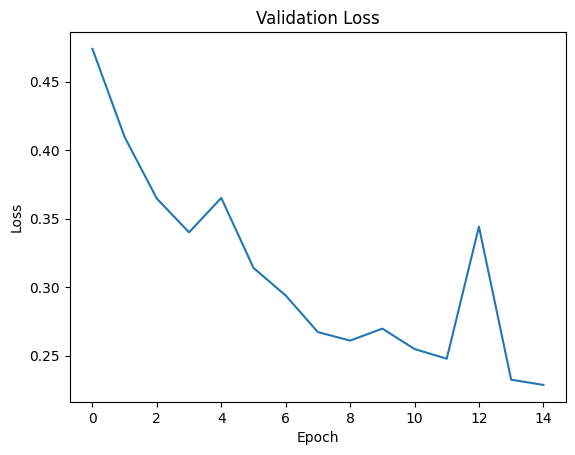

In [ ]:
val_loss = history.history['val_loss']

plt.plot(val_loss)
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(32,32),
                                                  batch_size=64, class_mode='binary', shuffle=False)

Found 2000 images belonging to 2 classes.


In [ ]:
scores = modelVGG19.evaluate(test_generator)

print('Baseline error: %.2f' % (1-scores[1]))
print("Accuracy = %.2f" %scores[1])

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - accuracy: 0.9384 - loss: 0.1582 - precision: 0.4727 - recall: 0.4487
Baseline error: 0.10
Accuracy = 0.90


In [ ]:
# Make predictions on the test data
predict_prob = modelVGG19.predict(test_generator)
labels = [0 if pred < 0.5 else 1 for pred in predict_prob]

# Calculate accuracy
accuracy = np.sum(np.array(test_generator.labels) == np.array(labels)) / len(labels)

# Print the accuracy
print("\nAccuracy:", accuracy)

cm = confusion_matrix(test_generator.labels, labels)
print("\nConfusion Matrix:")
print(cm)

# Compute the classification report
class_names = test_generator.class_indices.keys()
classification_rep = classification_report(test_generator.labels, labels, target_names=class_names)
print("\nClassification Report:")
print(classification_rep)

# Calculate the average precision (mAP)
mAP = average_precision_score(test_generator.labels,  predict_prob)
print("\nMean Average Precision (mAP):", mAP)

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step

Accuracy: 0.899

Confusion Matrix:
[[963  37]
 [165 835]]

Classification Report:
              precision    recall  f1-score   support

        FAKE       0.85      0.96      0.91      1000
        REAL       0.96      0.83      0.89      1000

    accuracy                           0.90      2000
   macro avg       0.91      0.90      0.90      2000
weighted avg       0.91      0.90      0.90      2000


Mean Average Precision (mAP): 0.9739381923751604


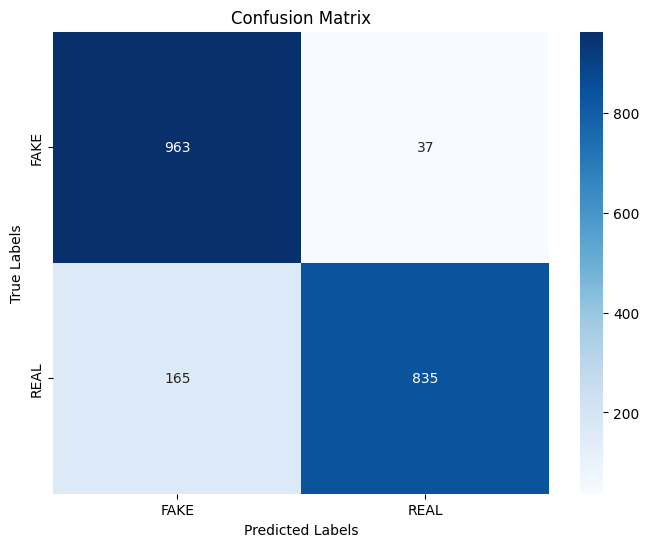

In [ ]:
import seaborn as sns

# Confusion matrix
cm = confusion_matrix(test_generator.labels, labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

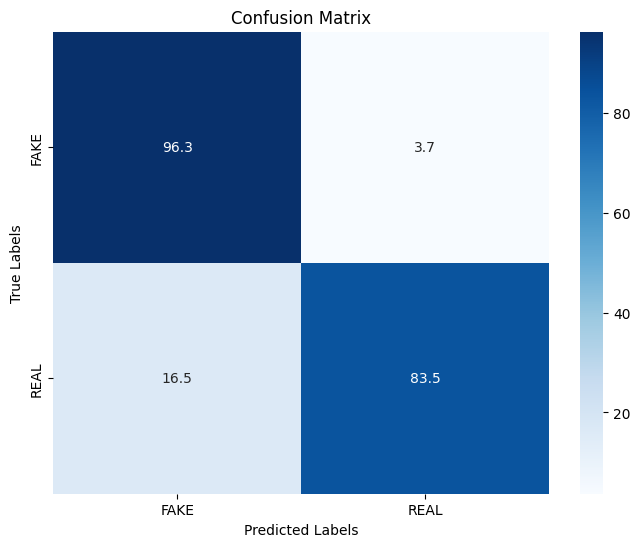

In [ ]:
# Confusion matrix
cm = confusion_matrix(test_generator.labels, labels)
cm_percent = cm / cm.sum(axis=1).reshape(-1, 1) * 100

plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent, annot=True, cmap='Blues', fmt='.1f', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
def make_class_specific_gradcam(img_array, model, last_conv_layer_name, class_indices):
    """
    Generate Grad-CAM heatmaps for specific classes.

    Parameters:
    - img_array: The input image as a preprocessed numpy array.
    - model: The trained model.
    - last_conv_layer_name: The name of the last convolutional layer in the model.
    - class_indices: Dictionary of class labels and their corresponding indices.

    Returns:
    - Dictionary of heatmaps for each class.
    """
    # Create a dictionary to store heatmaps for each class
    heatmaps = {}

    for class_label, index in class_indices.items():
        # Create a submodel that outputs the last conv layer and the model's output
        grad_model = tf.keras.models.Model(
            [model.inputs],
            [model.get_layer(last_conv_layer_name).output, model.output]
        )

        # Calculate gradients of the output w.r.t the chosen class index
        with tf.GradientTape() as tape:
            conv_outputs, predictions = grad_model(img_array)
            # Modification: Check the shape of predictions and access appropriately
            if predictions.shape[1] > 1:
                class_channel = predictions[:, index]
            else:
                class_channel = predictions  # Use the single output value for binary classification

        # Calculate the gradients of the specific class
        grads = tape.gradient(class_channel, conv_outputs)

        # Pool the gradients across width and height dimensions
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

        # Weight the feature map by the pooled gradients
        conv_outputs = conv_outputs[0]
        heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
        heatmap = tf.squeeze(heatmap)

        # Normalize the heatmap for visualization
        heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
        heatmaps[class_label] = heatmap.numpy()

    return heatmaps

In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

def display_class_specific_heatmaps(img_path, heatmaps, alpha=0.4):
    """
    Display the original image with heatmaps for each class.

    Parameters:
    - img_path: The file path of the original image.
    - heatmaps: Dictionary of class-specific heatmaps.
    - alpha: The transparency factor for overlaying heatmaps.
    """
    # Load and prepare the original image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Create subplots
    fig, axs = plt.subplots(1, len(heatmaps) + 1, figsize=(15, 5))
    axs[0].imshow(img)
    axs[0].set_title("Original Image")
    axs[0].axis("off")

    # Display each heatmap with the image
    for i, (class_label, heatmap) in enumerate(heatmaps.items()):
        # Resize the heatmap to match the image dimensions
        heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
        heatmap_resized = np.uint8(255 * heatmap_resized)
        heatmap_colormap = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

        # Overlay the heatmap on the original image
        superimposed_img = cv2.addWeighted(img, 1 - alpha, heatmap_colormap, alpha, 0)
        axs[i + 1].imshow(superimposed_img)
        axs[i + 1].set_title(f"Grad-CAM: {class_label}")
        axs[i + 1].axis("off")

    plt.show()


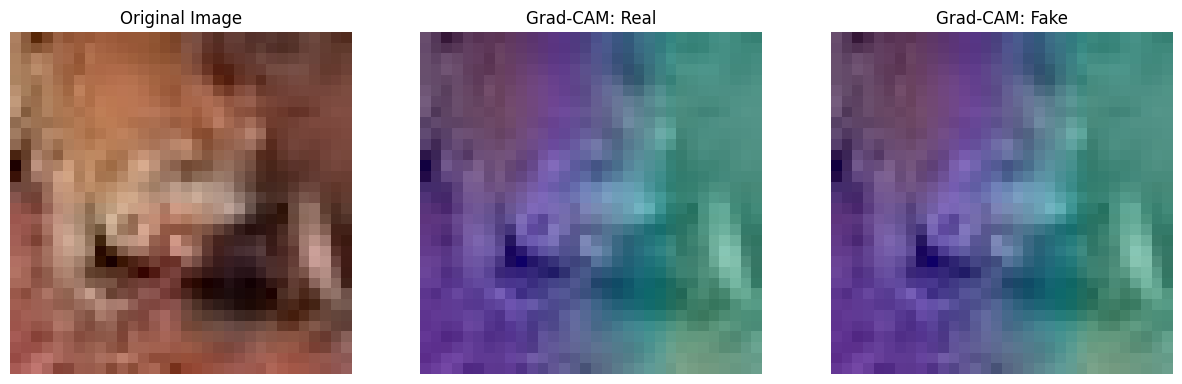

In [ ]:
# Sample image path from the test set
test_img_path = '/content/working/test/REAL/0001 (7).jpg'
img_array = tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(test_img_path, target_size=(32, 32)))
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0  # Rescale like in training

# Define class indices
class_indices = {'Real': 0, 'Fake': 1}

# Generate Grad-CAM heatmaps for each class
last_conv_layer_name = "block5_conv4"
heatmaps = make_class_specific_gradcam(img_array, modelVGG19, last_conv_layer_name, class_indices)

# Display the results
display_class_specific_heatmaps(test_img_path, heatmaps)
